# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф.

## Изучение данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from joblib import dump, load
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Нам предоставлены данные вещественного типа и столбец is_ultra - целого.

In [5]:
df.query('is_ultra == 0')['is_ultra'].count() / len(df) * 100

69.35283136278781

In [6]:
df.query('is_ultra == 1')['is_ultra'].count() / len(df) * 100

30.647168637212197

69,4% составляют тарифы smart и 30,6% ultra.

## Разбиваем данные на выборки

In [7]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345, stratify=target)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345, stratify=target_valid)

In [8]:
print(features_train.shape,target_train.shape,
      features_valid.shape, target_valid.shape, 
      features_test.shape, target_test.shape)

(1928, 4) (1928,) (643, 4) (643,) (643, 4) (643,)


## Исследование моделей

Классификация деревом решений имеет точность: 0.80248833592535


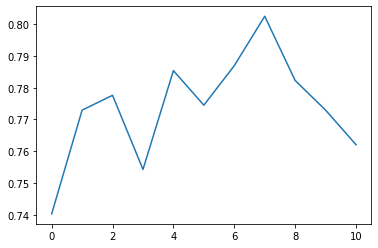

In [9]:
best_accuracy = 0
lst = []
for depth in range(1, 12):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions)
    lst.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
dump(best_model, 'best_model.joblib')
model_tree_classifier = load('best_model.joblib')
print('Классификация деревом решений имеет точность:', best_accuracy)
plt.plot(lst);

Классификация модели случайного леса имеет точность: 0.8102643856920684


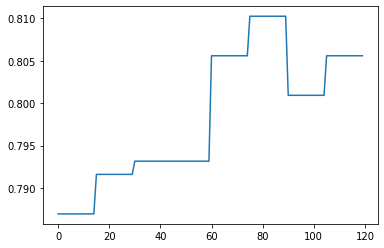

In [10]:
# Wall time: 23.2 s
best_accuracy = 0
lst = []
for est in range(10, 81, 10):
    for depth in range(1, 16):
        model = RandomForestClassifier(random_state=12345, n_estimators=est)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        accuracy = accuracy_score(target_valid, predictions)
        lst.append(accuracy)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
dump(best_model, 'best_model.joblib')
model_forest_classifier = load('best_model.joblib')
print('Классификация модели случайного леса имеет точность:', best_accuracy)
plt.plot(lst);

In [11]:
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
accuracy = accuracy_score(target_valid, predictions)
print('Классификация модели логистической регрессии имеет точность:', accuracy)

Классификация модели логистической регрессии имеет точность: 0.7387247278382582


*** Вывод: ***

После исследования моделей я пришла к выводу, что наиболее лучшие результаты дает модель случайного леса.

## Проверка модели на тестовой выборке

In [12]:
predictions = model_forest_classifier.predict(features_test)
accuracy = accuracy_score(target_test, predictions)
print('Классификация модели случайного леса на тестовой выборке имеет точность:', accuracy)
predictions = model_tree_classifier.predict(features_test)
accuracy = accuracy_score(target_test, predictions)
print('Классификация модели дерева решений на тестовой выборке имеет точность:', accuracy)

Классификация модели случайного леса на тестовой выборке имеет точность: 0.7978227060653188
Классификация модели дерева решений на тестовой выборке имеет точность: 0.7838258164852255


In [13]:
features_train_valid = pd.concat([features_train, features_valid])
target_train_valid = pd.concat([target_train, target_valid])
model_forest_classifier.fit(features_train_valid, target_train_valid)
predictions = model_forest_classifier.predict(features_test)
accuracy = accuracy_score(target_test, predictions)
print('Точность на дообученной модели:', accuracy)

Точность на дообученной модели: 0.8304821150855366


Получилась точность на 0.03 лучше.

## Проверка модели на адекватность

In [14]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(target_valid, target_test)
dummy_clf.predict(target_valid)
dummy_clf.score(target_valid, target_test)
dummy_clf.score(target_valid, target_test)

0.6936236391912908

Модель адекватна

## Вывод

Мною было проведено исследование разных моделей, я пришла к выводу, что наилучшей моделью является модель случайного леса. При проверке на тестовых данных я получила точность 0.79.